## Setup

Import the required libraries and initialize them:

In [1]:
#python 2 issues
# load model wont work , load weights is a workaround.
# if ros noetic and python 3 is AVAILABle  use load model instead.
# DAta augmentation (KERAS) is experimental, not retrocompatible for keras directory to trainin batches
batch_size=128
img_width=300
img_height=300
#train_data_dir ='/home/oscar/Videos/videos_to_keras_train/'
train_data_dir ='/home/roboworks/Videos/videos_to_keras_train/'

## Just a local path where to save the images




import tensorflow

from tensorflow.keras import layers , Sequential
num_classes = 73
model = Sequential([
  
  layers.Conv2D(16, 3, padding='same', activation='relu' , input_shape=(img_height, img_width,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
      
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.load_weights('weights_ycb')
model.summary()

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [ ]:
import numpy as np
images_test= np.load('imgs_test.npy',allow_pickle=True)

img=tensorflow.image.resize(images_test[0],(300,300))
test_imgs=np.zeros((1,300,300,3))
for image in images_test:
    img=tensorflow.image.resize(image,(300,300))
    new=np.expand_dims(img.numpy(),axis=0)
    test_imgs=np.concatenate((test_imgs,new))
    
np.argmax(model.predict(test_imgs),axis=1)
 

In [2]:
from std_srvs.srv import Empty, Trigger, TriggerRequest
import cv2

In [3]:
from cv_bridge import CvBridge, CvBridgeError
import rospy
#import cv2
import ros_numpy
import numpy as np
from tmc_tabletop_segmentator.srv import TabletopSegmentation
from tmc_tabletop_segmentator.srv import TabletopSegmentationRequest
from sensor_msgs.msg import Image
from std_msgs.msg import String
#import tf
import tf2_ros
from tf2_sensor_msgs.tf2_sensor_msgs import do_transform_cloud
import geometry_msgs.msg
from utils_notebooks import *


the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
#import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped
import moveit_commander
import moveit_msgs.msg

import sys

from utils_notebooks import *
#from utils_task1 import *
import cv2
import os

# REMEMBER TO RUN MOVEIT 
# roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [5]:


cv2.__version__

## CHECK  CV VERSIONS IN CASE YOU WONT USE SURF 
## 3.3.1 is an old dependence use sys path remove if needed


'3.3.1-dev'

In [6]:
#! roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [7]:


bridge = CvBridge()
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])#whole_body.go(wb)


In [8]:

def static_tf_publish(cents, quaternions=[],label=''):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        #print quats
    else:
        quats=np.asarray(quaternions)
        #print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan , rejected')
        else:
            #### first place a dissolving tf wrt head sensor  in centroids

            broadcaster.sendTransform((x,y,z),(0,0,0,1), rospy.Time.now(), 'Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            if xyz_map[-1] <.2:
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Floor_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
            if    (xyz_map[-1] >.4)and (xyz_map[-1] <.5):
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Table_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
    return True


In [9]:
#!python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation.py

In [10]:
#! python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation_backup.py



In [11]:

rospy.init_node("recognition")


In [12]:
def pose_2_np(wp_p):
   
    return np.asarray((wp_p.pose.position.x,wp_p.pose.position.y,wp_p.pose.position.z)) , np.asarray((wp_p.pose.orientation.w,wp_p.pose.orientation.x,wp_p.pose.orientation.y, wp_p.pose.orientation.z)) 
def np_2_pose(position,orientation):
    wb_p= geometry_msgs.msg.PoseStamped()
    
    wb_p.pose.position.x= position[0]
    wb_p.pose.position.y= position[1]
    wb_p.pose.position.z= position[2]
    wb_p.pose.orientation.w= orientation[0]
    wb_p.pose.orientation.x= orientation[1]
    wb_p.pose.orientation.y= orientation[2]
    wb_p.pose.orientation.z= orientation[3]
    return wb_p

In [13]:
def gaze_point(x,y,z):
    
    
    
    head_pose = head.get_current_joint_values()
    head_pose[0]=0.0
    head_pose[1]=0.0
    head.set_joint_value_target(head_pose)
    head.go()
    
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    """ 
    arm_pose=arm.get_current_joint_values()
    arm_pose[0]=.1
    arm_pose[1]= -0.3
    arm.set_joint_value_target(arm_pose)
    arm.go()"""
    
    e =tf.transformations.euler_from_quaternion(rot)
    #print('i am at',trans,np.rad2deg(e)[2])
    #print('gaze goal',x,y,z)
    #tf.transformations.euler_from_quaternion(rot)


    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]


    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z

    D_th= np.arctan2(D_y,D_x)
    print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))

    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)

    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct

    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))

    head_pose [1]=-tilt_correct
    
    
    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

In [14]:
rgbd = RGBD()
#a listener xtion rgbd listener class , (check utils for methods )
# TF is one of the most powerfull underated Ros tools, I recomend to understand it and use it as often as possible.
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()


In [15]:
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)

clear_octo_client.wait_for_service(timeout=1.0)


In [16]:
# initialize ROS publisher
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)
goal = MoveBaseGoal()
navclient = actionlib.SimpleActionClient('/move_base/move', MoveBaseAction)
    
# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node
def move_base(goal_x,goal_y,goal_yaw,time_out=10):
    pose = PoseStamped()
    pose.header.stamp = rospy.Time.now()
    pose.header.frame_id = "map"
    pose.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    pose.pose.orientation = Quaternion(*quat)


    # create a MOVE BASE GOAL
    goal = MoveBaseGoal()
    goal.target_pose = pose

    # send message to the action server
    navclient.send_goal(goal)

    # wait for the action server to complete the order
    navclient.wait_for_result(timeout=rospy.Duration(time_out))

    # print result of navigation
    action_state = navclient.get_state()
    return navclient.get_state()

In [17]:
def seg_square_imgs(lower=2000,higher=50000,reg_ly=0,reg_hy=1000,reg_lx=0,reg_hx=1000,plt_images=False): 
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):

        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])


            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux= iimmg[boundRect[1]:boundRect[1]+max(boundRect[3],boundRect[2]),boundRect[0]:boundRect[0]+max(boundRect[3],boundRect[2])]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            #img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+max(boundRect[2],boundRect[3]), boundRect[1]+max(boundRect[2],boundRect[3])), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy and  cX > reg_lx and cX < reg_hx   ):

                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
                images.pop()
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    return(cents,np.asarray(points), images)

In [18]:
def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000,plt_images=False): 
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux= iimmg[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

In [19]:
def move_d_to(target_distance=0.5,target_link='Floor_Object0'):

    obj_tar,_ =  listener.lookupTransform('map',target_link,rospy.Time(0))
    robot, _ =  listener.lookupTransform('map','base_link',rospy.Time(0))
    pose, quat =  listener.lookupTransform('base_link',target_link,rospy.Time(0))

    D=np.asarray(obj_tar)-np.asarray(robot)
    d=D/np.linalg.norm(D)
    if target_distance==-1:
        new_pose=np.asarray(robot)
    else:
        new_pose=np.asarray(obj_tar)-target_distance*d
    
    broadcaster.sendTransform(new_pose,(0,0,0,1), rospy.Time.now(), 'D_from_object','map')
    wb_v= whole_body.get_current_joint_values()

    arm.set_named_target('go')
    arm.go()


    succ=move_base( new_pose[0],new_pose[1],         np.arctan2(pose[1],pose[0])+wb_v[2])
    return succ   


In [20]:

def correct_points(low=.27,high=1000):
    data = rospy.wait_for_message('/hsrb/head_rgbd_sensor/depth_registered/rectified_points', PointCloud2)
    np_data=ros_numpy.numpify(data)
    trans,rot=listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) 
    
    eu=np.asarray(tf.transformations.euler_from_quaternion(rot))
    t=TransformStamped()
    rot=tf.transformations.quaternion_from_euler(-eu[1],0,0)
    t.header.stamp = data.header.stamp
    
    t.transform.rotation.x = rot[0]
    t.transform.rotation.y = rot[1]
    t.transform.rotation.z = rot[2]
    t.transform.rotation.w = rot[3]

    cloud_out = do_transform_cloud(data, t)
    np_corrected=ros_numpy.numpify(cloud_out)
    corrected=np_corrected.reshape(np_data.shape)

    img= np.copy(corrected['y'])

    img[np.isnan(img)]=2
    img3 = np.where((img>low)&(img< 0.99*(trans[2])),img,255)
    return img3
def plane_seg_square_imgs(lower=500 ,higher=50000,reg_ly= 30,reg_hy=600,plt_images=True):
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    img=np.copy(image)
    img3= correct_points()


    _,contours, hierarchy = cv2.findContours(img3.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):

        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])


            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux= iimmg[boundRect[1]:boundRect[1]+max(boundRect[2],boundRect[3]),boundRect[0]:boundRect[0]+max(boundRect[2],boundRect[3])]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):

                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

In [21]:

base_vel_pub = rospy.Publisher('/hsrb/command_velocity', Twist, queue_size=1)
def move_abs(vx,vy,vw):
    twist = Twist()
    twist.linear.x = vx
    twist.linear.y = vy
    twist.angular.z = vw / 180.0 * np.pi  
    base_vel_pub.publish(twist)

In [22]:
def gazebo_2_world(x,y):

    x_world= x+2.1
    y_world= -(y-1.2)
    return (x_world,y_world)

def world_2_gazebo(y_world , x_world):

    x= ( x_world - 2.1)
    y= (-y_world + 1.2) 
    return (x , y)

_path_model = "/home/roboworks/Codes/catkin_mio/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 


objs=os.listdir(_path_model)
objs.sort()


In [26]:
obj_ind= 15-94+46

len(objs)

94

In [401]:
obj_ind+=1



In [402]:
 

objs[obj_ind]

'ycb_071_nine_hole_peg_test'

In [403]:
path='/home/roboworks/Videos/videos_to_keras_train/'
#obj_ind+=1 
obj_name = ''.join(objs[obj_ind].split('_')[1:])
obj_name
try: 
    os.mkdir(path+obj_name) 
except OSError as error: 
    print(error)  
delete_object('spawned')
move_base(0.51,0.35,0.5*np.pi)


1

In [404]:
delete_object('spawned')
move_base(0.51,0.35,0.5*np.pi)
#x_map,y_map, z_map = 1.0,1.0,0.005
x_map,y_map, z_map = 1.0,1.35,0.005
x_gaz,y_gaz= world_2_gazebo(x_map,y_map)
eu_i,eu_j,eu_k = 3.1416  ,0,0
spawn_object('spawned',objs[obj_ind], x_gaz+np.random.randn()*0.1,  y_gaz+np.random.randn()*0.1, z_map ,eu_i,eu_j,eu_k )
##################
gaze_point(x_map,y_map,z_map)


[INFO] [1646356723.519157, 17682.810000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646356723.523321, 17682.810000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1646356723.526496, 17682.810000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646356723.540501, 17682.810000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646356723.882240, 17682.897000]: Spawn status: SpawnModel: Successfully spawned entity
('relative to robot', (-0.5141778527942742, -1.0614881465429342, -115.84524146808104))


True

In [405]:
#_,_,_ =seg_pca(reg_ly=100,plt_images=True)# seg_square_imgs(plt_images=True)

In [406]:
#plt.imshow(rgbd.get_image())
cents,_,_ = seg_square_imgs(reg_ly=100,lower=1110, plt_images=True)

('cX,cY', 314, 241)
[-0.01908205  0.00684921  1.4993148 ]


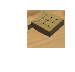

In [407]:
cents,_,_ =plane_seg_square_imgs(lower=0,plt_images=True)

[INFO] [1646356750.448579, 17689.005000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646356750.453724, 17689.005000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1646356750.459879, 17689.005000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646356750.475627, 17689.005000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646356750.762414, 17689.086000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 60, 289)
[-0.6056649   0.12939882  1.3874428 ]
('cX,cY', 534, 352)
[0.47656068 0.25487313 1.2345812 ]
('cX,cY', 115, 205)
[-0.56120306 -0.10267992  1.6497921 ]
('cX,cY', 455, 135)
[ 0.35853282 -0.41366616  1.8596278 ]
np.save
('cX,cY', 325, 251)
[0.00871375 0.02964136 1.4349719 ]
np.save
[INFO] [1646356758.001693, 17690.667000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646356758.005777, 17690.670000]: Spawn: [0.         0.         0.99950667 0.03140716]
[INFO] [1646356758.008210, 17690.670000]: Waiting for service /gazebo/spawn_sdf

[INFO] [1646356826.512035, 17705.778000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 56, 292)
[-0.6093127   0.13921124  1.3758856 ]
('cX,cY', 458, 397)
[0.2822749  0.32975337 1.1464648 ]
('cX,cY', 532, 350)
[0.48661026 0.24998285 1.240334  ]
('cX,cY', 105, 208)
[-0.5740806  -0.08317755  1.6271328 ]
('cX,cY', 461, 141)
[ 0.35685495 -0.38609588  1.8445647 ]
np.save
('cX,cY', 305, 277)
[-0.04176606  0.09229535  1.3435179 ]
np.save
[INFO] [1646356834.137819, 17707.473000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646356834.140720, 17707.473000]: Spawn: [0.         0.         0.92977751 0.36812196]
[INFO] [1646356834.143710, 17707.473000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646356834.147876, 17707.473000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646356834.441773, 17707.545000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 44, 289)
[-0.6846246   0.11870274  1.4004154 ]
('cX,cY', 109, 207)
[-0.56476283 -0.0893396   1.6376159

[0.22627674 0.364787   1.1053247 ]
('cX,cY', 531, 352)
[0.47368693 0.2565027  1.2328902 ]
np.save
('cX,cY', 329, 280)
[0.02546067 0.0990115  1.3423306 ]
np.save
[INFO] [1646356907.093034, 17723.637000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646356907.096876, 17723.637000]: Spawn: [0.         0.         0.75011238 0.66131038]
[INFO] [1646356907.099397, 17723.637000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646356907.107264, 17723.637000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646356907.412413, 17723.727000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 42, 293)
[-0.6612714   0.14663813  1.3678603 ]
('cX,cY', 293, 260)
[-0.0503662   0.05420006  1.4382105 ]
('cX,cY', 526, 351)
[0.46645522 0.24760425 1.243258  ]
('cX,cY', 435, 137)
[ 0.14760387 -0.37584096  1.7789047 ]
np.save
('cX,cY', 272, 247)
[-0.12366219  0.0181047   1.4424138 ]
np.save
[INFO] [1646356915.818270, 17725.548000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646356915.821897,

[INFO] [1646356983.558276, 17740.284000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 40, 292)
[-0.61614376  0.13806652  1.3773128 ]
('cX,cY', 378, 448)
[0.11171144 0.3967418  1.0678358 ]
('cX,cY', 523, 345)
[0.47495365 0.24632414 1.244958  ]
('cX,cY', 99, 209)
[-0.60288554 -0.08415527  1.626161  ]
('cX,cY', 430, 155)
[ 0.34566784 -0.38950017  1.8495018 ]
('cX,cY', 419, 199)
[ 0.29506335 -0.12008873  1.6611177 ]
('cX,cY', 288, 194)
[-0.07527776 -0.137203    1.7030023 ]
np.save
('cX,cY', 381, 225)
[ 0.17343457 -0.04379     1.5125206 ]
np.save
[INFO] [1646356991.438879, 17741.964000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646356991.442220, 17741.964000]: Spawn: [0.         0.         0.45399148 0.89100602]
[INFO] [1646356991.446158, 17741.967000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646356991.455158, 17741.970000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646356991.789779, 17742.054000]: Spawn status: SpawnModel: Successfully spawned enti

('cX,cY', 43, 294)
[-0.61676985  0.14384194  1.3704234 ]
('cX,cY', 524, 346)
[0.4760991  0.24358582 1.2479714 ]
np.save
('cX,cY', 295, 271)
[-0.05773007  0.07883283  1.3632424 ]
np.save
[INFO] [1646357066.816034, 17758.065000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357066.821556, 17758.068000]: Spawn: [0.         0.         0.12533353 0.99211466]
[INFO] [1646357066.827807, 17758.068000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357066.870618, 17758.080000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357067.106033, 17758.140000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 401, 424)
[0.15915097 0.3610704  1.1099956 ]
('cX,cY', 513, 353)
[0.43556055 0.24940881 1.2414838 ]
('cX,cY', 554, 228)
[ 0.66346276 -0.03517918  1.5786159 ]
cent out of region... rejected
np.save
('cX,cY', 303, 311)
[-0.03418431  0.16419245  1.2661479 ]
np.save
[INFO] [1646357072.820452, 17759.355000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357072.824228, 177

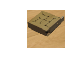

In [408]:
delete_object('spawned')
num_imgs=50
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))
    if contador >=350:
        break
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz +np.random.randn()*0.1,  y_gaz+np.random.randn()*0.1,  0.05,eu_i,eu_j,eu_k )
    rospy.sleep(.21)
    
    cents,xyz, images=seg_square_imgs(reg_ly=100)
    if len(images)!=0:
        contador=len(os.listdir(path+'/'+obj_name))
        cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        
        
        print 'np.save'
    else: 
        print (len(images))

    cents,xyz, images=plane_seg_square_imgs(lower=0,reg_ly=100)
    
    delete_object('spawned')
    if len(images)!=0:
        contador=len(os.listdir(path+'/'+obj_name))
        cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        
        
        print 'np.save'
    else: 
        print (len(images))


#move_base(1.1,1.3,np.pi)

In [409]:
delete_object('spawned')

move_base(1.3,1.0,0.0*np.pi)


1

In [410]:

move_base(1.3,1.0,0.0*np.pi)
x_map,y_map, z_map = 1.2,1.8,0.405
x_gaz,y_gaz= world_2_gazebo(x_map,y_map)
eu_i,eu_j,eu_k = 3.1416  ,0,0
spawn_object('spawned',objs[obj_ind], x_gaz+np.random.randn()*0.01,  y_gaz+np.random.randn()*0.05, z_map ,eu_i,eu_j,eu_k )
gaze_point(x_map,y_map,z_map)

[INFO] [1646357155.258576, 17785.017000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357155.263284, 17785.020000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1646357155.267135, 17785.020000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357155.279278, 17785.020000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357155.622148, 17785.107000]: Spawn status: SpawnModel: Successfully spawned entity
('relative to robot', (0.037947530910131366, -0.7783135213323162, -87.20869170819506))
Exorcist alert


True

('cX,cY', 337, 238)
[ 0.03011995 -0.00148716  0.9255769 ]
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected


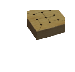

In [411]:
cents,_,_ = seg_square_imgs(lower=10,reg_ly=100 ,higher=2400, reg_hy=300,plt_images=True)#reg_ly=100 , reg_hy=300,plt_images=True)

[INFO] [1646357183.188209, 17791.758000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357183.192452, 17791.761000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1646357183.194828, 17791.761000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357183.215571, 17791.761000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357183.453971, 17791.830000]: Spawn status: SpawnModel: Successfully spawned entity
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
('cX,cY', 289, 238)
[-0.05682751 -0.00319552  0.96577615]
('cX,cY', 293, 238)
[-0.04242661 -0.00233357  0.9248987 ]
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
np.save
[INFO] [1646357186.979074, 17792.616000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357186.982452, 17792.616000]: Spawn: [0.         0.         0.99950667 0.03140716]
[INFO]

[INFO] [1646357221.363050, 17800.350000]: Spawn status: SpawnModel: Successfully spawned entity
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
('cX,cY', 294, 245)
[-0.04349225  0.00899901  0.9441683 ]
('cX,cY', 295, 245)
[-0.0416881   0.01074856  0.90370476]
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
np.save
[INFO] [1646357224.754402, 17801.091000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357224.759914, 17801.091000]: Spawn: [0.         0.         0.94088174 0.33873522]
[INFO] [1646357224.789934, 17801.106000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357224.794211, 17801.106000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357225.036512, 17801.160000]: Spawn status: SpawnModel: Successfully spawned entity
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent

[0.05438765 0.01473895 0.94181174]
('cX,cY', 350, 251)
[0.04888774 0.01780755 0.9046458 ]
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
np.save
[INFO] [1646357264.163231, 17809.581000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357264.169595, 17809.581000]: Spawn: [0.         0.         0.79015632 0.61290537]
[INFO] [1646357264.183656, 17809.581000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357264.201265, 17809.602000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357264.466111, 17809.644000]: Spawn status: SpawnModel: Successfully spawned entity
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
('cX,cY', 311, 246)
[-0.01371146  0.0072082   0.9522986 ]
('cX,cY', 311, 246)
[-0.01559433  0.01240432  0.9094083 ]
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out o

[-0.03006933  0.0107634   0.90150887]
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
np.save
[INFO] [1646357302.548658, 17817.960000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357302.551316, 17817.960000]: Spawn: [0.         0.         0.56208453 0.82707979]
[INFO] [1646357302.554294, 17817.960000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357302.565994, 17817.966000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357302.686062, 17817.978000]: Spawn status: SpawnModel: Successfully spawned entity
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
('cX,cY', 312, 246)
[-0.01284243  0.00381481  0.9479876 ]
('cX,cY', 311, 246)
[-0.01299628  0.01078034  0.9003991 ]
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected


[-0.06790425  0.00602349  0.95431304]
('cX,cY', 276, 243)
[-0.07111879  0.00842746  0.91652495]
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
np.save
[INFO] [1646357339.318968, 17825.883000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357339.322311, 17825.883000]: Spawn: [0.         0.         0.27899174 0.9602935 ]
[INFO] [1646357339.324664, 17825.883000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357339.342961, 17825.883000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357339.652896, 17825.967000]: Spawn status: SpawnModel: Successfully spawned entity
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
('cX,cY', 376, 250)
[0.09904245 0.01769549 0.93776023]
('cX,cY', 374, 250)
[0.08944162 0.01878095 0.9022162 ]
cent out of region... rejected
cent out of region... rejected
cent out o

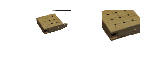

In [412]:
delete_object('spawned')
num_imgs=50
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))
    if contador >=200:
        break
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz+np.random.randn()*0.01,  y_gaz+np.random.randn()*0.05, z_map ,eu_i,eu_j,eu_k )
    rospy.sleep(.21)
    

    cents,xyz, images=seg_square_imgs(lower=10,reg_ly=100 , reg_hy=300,plt_images=True)
    delete_object('spawned')
    if len(images)!=0:
        contador=len(os.listdir(path+'/'+obj_name))
        cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        
        
        print 'np.save'
    else: 
        print (len(images))


#move_base(1.1,1.3,np.pi)

In [413]:
delete_object('spawned')

move_base(2.5,1.15,np.pi)

1

In [414]:

move_base(2.5,1.0,np.pi)
x_map,y_map, z_map = 2.5,1.8,0.005
x_gaz,y_gaz= world_2_gazebo(x_map,y_map)
eu_i,eu_j,eu_k = 3.1416  ,0,0
spawn_object('spawned',objs[obj_ind], x_gaz+np.random.randn()*0.01,  y_gaz+np.random.randn()*0.05, z_map ,eu_i,eu_j,eu_k )
gaze_point(x_map,y_map,z_map)

[INFO] [1646357433.716317, 17854.197000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357433.719804, 17854.197000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1646357433.721900, 17854.197000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357433.745311, 17854.203000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357433.997072, 17854.245000]: Spawn status: SpawnModel: Successfully spawned entity
('relative to robot', (0.07198869471138059, -0.8147593763613269, -84.95069938476838))


True

('cX,cY', 396, 280)
[0.15517154 0.08694131 1.1641428 ]


array([[0.15517154, 0.08694131, 1.1641428 ]], dtype=float32)

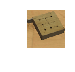

In [415]:
cents,_,_ = plane_seg_square_imgs(lower=10,plt_images=True)
cents

[INFO] [1646357466.337539, 17861.499000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357466.342828, 17861.499000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1646357466.344978, 17861.499000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357466.351648, 17861.499000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357466.653201, 17861.559000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 330, 280)
[0.01444911 0.08790964 1.162173  ]
np.save
[INFO] [1646357471.670341, 17862.531000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357471.673328, 17862.531000]: Spawn: [0.         0.         0.99950667 0.03140716]
[INFO] [1646357471.675047, 17862.531000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357471.688987, 17862.534000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357472.020849, 17862.600000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 355, 279)
[0.06802017 0.08391187 1.164223

[INFO] [1646357541.612514, 17877.726000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 383, 297)
[0.13359939 0.11746427 1.1392398 ]
np.save
[INFO] [1646357545.769249, 17878.572000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357545.772905, 17878.572000]: Spawn: [0.         0.         0.86074326 0.50903933]
[INFO] [1646357545.775440, 17878.572000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357545.799327, 17878.581000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357546.104519, 17878.656000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 386, 293)
[0.14072847 0.10792583 1.1472268 ]
np.save
[INFO] [1646357550.181100, 17879.550000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357550.184130, 17879.550000]: Spawn: [0.         0.         0.84432919 0.53582481]
[INFO] [1646357550.188598, 17879.550000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357550.195644, 17879.550000]: Calling service /gazebo/spawn_sdf_model
[INF

[INFO] [1646357620.778617, 17894.565000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 354, 281)
[0.0718127  0.08321145 1.1547495 ]
np.save
[INFO] [1646357625.047604, 17895.519000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357625.052685, 17895.522000]: Spawn: [0.         0.         0.4817547  0.87630611]
[INFO] [1646357625.059182, 17895.525000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357625.069341, 17895.528000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357625.360747, 17895.588000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 314, 291)
[-0.01027934  0.10578112  1.1389846 ]
np.save
[INFO] [1646357629.680443, 17896.515000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357629.683357, 17896.515000]: Spawn: [0.         0.         0.45399148 0.89100602]
[INFO] [1646357629.685355, 17896.515000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357629.691797, 17896.515000]: Calling service /gazebo/spawn_sdf_model
[

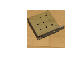

In [416]:
delete_object('spawned')
num_imgs=50
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))
    if contador >=200:
        break
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz+np.random.randn()*0.01,  y_gaz+np.random.randn()*0.05, z_map ,eu_i,eu_j,eu_k )
    rospy.sleep(.21)
    

    #cents,xyz, images=seg_square_imgs(reg_ly=150 , reg_hy=300,reg_lx=100,reg_hx=400,plt_images=True)
    cents,xyz, images=plane_seg_square_imgs(lower=10,plt_images=True)
    delete_object('spawned')
    if len(images)!=0:
        contador=len(os.listdir(path+'/'+obj_name))
        cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        
        
        print 'np.save'
    else: 
        print (len(images))


#move_base(1.1,1.3,np.pi)

In [417]:
delete_object('spawned')
move_base(2.25,4,0.0*np.pi)


1

In [418]:
move_base(2.25,4,0.0*np.pi)

x_map,y_map, z_map = 2.25,4.65,0.55
x_gaz,y_gaz= world_2_gazebo(x_map,y_map)
eu_i,eu_j,eu_k = 3.1416  ,0,0
spawn_object('spawned',objs[obj_ind], x_gaz+np.random.randn()*0.01,  y_gaz+np.random.randn()*0.05, z_map ,eu_i,eu_j,eu_k )
gaze_point(x_map,y_map,z_map)


[INFO] [1646357763.277845, 17932.152000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357763.281386, 17932.152000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1646357763.284714, 17932.152000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357763.301361, 17932.158000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357763.625489, 17932.233000]: Spawn status: SpawnModel: Successfully spawned entity
('relative to robot', (-0.04458377523353407, -0.6189967933792637, -94.11966362315054))
Exorcist alert


True

cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
('cX,cY', 376, 242)
[0.08480029 0.0090044  0.85983926]
('cX,cY', 379, 238)
[ 0.07559489 -0.0012607   0.6984753 ]


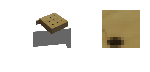

In [419]:
cents,_,_ = seg_square_imgs(lower=10,reg_ly=100 , reg_hy=300,plt_images=True)#reg_ly=100 , reg_hy=300,plt_images=True)

[INFO] [1646357794.991877, 17938.590000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357794.996572, 17938.590000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1646357795.007855, 17938.593000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357795.029522, 17938.593000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357795.314041, 17938.650000]: Spawn status: SpawnModel: Successfully spawned entity
cent out of region... rejected
cent out of region... rejected
cent out of region... rejected
('cX,cY', 272, 235)
[-0.07463402 -0.00662279  0.81673414]
('cX,cY', 272, 231)
[-0.06079561 -0.00960148  0.70955825]
np.save


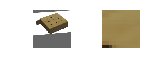

In [420]:
delete_object('spawned')
num_imgs=50
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))
    if contador >=200:
        break
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz+np.random.randn()*0.1,  y_gaz+np.random.randn()*0.05, z_map ,eu_i,eu_j,eu_k )
    rospy.sleep(.21)
    

    cents,xyz, images= seg_square_imgs(lower=10,reg_ly=100 , reg_hy=300,plt_images=True)#reg_ly=100 , reg_hy=300,plt_images=True)
    delete_object('spawned')
    if len(images)!=0:
        contador=len(os.listdir(path+'/'+obj_name))
        cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        if len (images)==2:
            contador=len(os.listdir(path+'/'+obj_name))
            cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
        
        print 'np.save'
    else: 
        print (len(images))


#move_base(1.1,1.3,np.pi)

In [421]:

x_map,y_map, z_map = 2.25,4.65,0.8
x_gaz,y_gaz= world_2_gazebo(x_map,y_map)
eu_i,eu_j,eu_k = 3.1416  ,0,0
spawn_object('spawned',objs[obj_ind], x_gaz+np.random.randn()*0.01,  y_gaz+np.random.randn()*0.05, z_map ,eu_i,eu_j,eu_k )
gaze_point(x_map,y_map,z_map)

[INFO] [1646357799.145376, 17939.397000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357799.153999, 17939.397000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1646357799.159075, 17939.400000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357799.173967, 17939.406000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357799.455668, 17939.463000]: Spawn status: SpawnModel: Successfully spawned entity
('relative to robot', (-0.04998690999376665, -0.6142871370291196, -94.65212795973316))
Exorcist alert


True

('cX,cY', 320, 223)
[-0.00259196 -0.01979251  0.79503095]


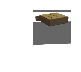

In [422]:
cents,_,_ = seg_square_imgs(reg_ly=150 , reg_hy=300,plt_images=True)

[INFO] [1646357834.633188, 17946.597000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357834.636175, 17946.597000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1646357834.638261, 17946.597000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357834.660609, 17946.600000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357834.987722, 17946.666000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 277, 198)
[-0.06572507 -0.06262477  0.8169031 ]
('cX,cY', 292, 207)
[-0.04411147 -0.04384864  0.7599603 ]
np.save
[INFO] [1646357838.739134, 17947.377000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357838.745478, 17947.380000]: Spawn: [0.         0.         0.99950667 0.03140716]
[INFO] [1646357838.747883, 17947.380000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357838.772588, 17947.389000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357839.044391, 17947.449000]: Spawn status: SpawnModel: Successfully spawn

[ 0.13374545 -0.0058089   0.75626683]
('cX,cY', 418, 247)
[0.10287355 0.00911887 0.591268  ]
('cX,cY', 464, 218)
[ 0.16395777 -0.0243602   0.6268647 ]
('cX,cY', 436, 216)
[ 0.13367757 -0.02634066  0.6334068 ]
np.save
[INFO] [1646357885.823140, 17956.476000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357885.826668, 17956.476000]: Spawn: [0.         0.         0.91775571 0.3971454 ]
[INFO] [1646357885.829106, 17956.476000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357885.857580, 17956.482000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357886.100573, 17956.545000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 374, 228)
[ 0.07653794 -0.01335813  0.7753531 ]
('cX,cY', 370, 241)
[0.0543375  0.00285562 0.61230016]
np.save
[INFO] [1646357889.496172, 17957.190000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357889.499805, 17957.193000]: Spawn: [0.         0.         0.90482818 0.4257769 ]
[INFO] [1646357889.506906, 17957.193000]: Waiting for se

/home/roboworks/.local/lib/python2.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice.


np.save
[INFO] [1646357935.486842, 17966.007000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357935.490867, 17966.010000]: Spawn: [0.         0.         0.68454839 0.72896742]
[INFO] [1646357935.492815, 17966.010000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357935.518374, 17966.022000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357935.785333, 17966.073000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 369, 225)
[ 0.07281952 -0.01804975  0.78263694]
('cX,cY', 398, 237)
[ 0.08959294 -0.00224509  0.6274759 ]
('cX,cY', 325, 230)
[ 0.00395229 -0.00992327  0.6480344 ]
np.save
[INFO] [1646357939.101160, 17966.724000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357939.103733, 17966.724000]: Spawn: [0.         0.         0.66131313 0.75010995]
[INFO] [1646357939.105757, 17966.724000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357939.113246, 17966.727000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357939.232075, 17966.739

[INFO] [1646357980.242974, 17974.728000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 392, 225)
[ 0.10233442 -0.01725934  0.78215516]
('cX,cY', 381, 237)
[ 0.07199681 -0.00163106  0.624919  ]
('cX,cY', 381, 207)
[ 0.07558065 -0.03967729  0.6758157 ]
np.save
[INFO] [1646357983.669199, 17975.400000]: Spawn: ycb_071_nine_hole_peg_test
[INFO] [1646357983.673782, 17975.400000]: Spawn: [0.         0.         0.33873868 0.9408805 ]
[INFO] [1646357983.677671, 17975.400000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1646357983.692622, 17975.400000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1646357983.964535, 17975.457000]: Spawn status: SpawnModel: Successfully spawned entity
('cX,cY', 351, 240)
[0.04470553 0.00655325 0.76275766]
('cX,cY', 340, 257)
[0.02120322 0.01909982 0.56743944]
('cX,cY', 405, 245)
[0.09465095 0.00541704 0.5992169 ]
np.save


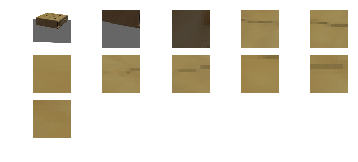

In [423]:
delete_object('spawned')
num_imgs=50
for i in range(num_imgs):
    contador=len(os.listdir(path+'/'+obj_name))
    if contador >=250:
        break
    eu_i,eu_j,eu_k = 3.1416 - i*(3.1416/num_imgs) ,0,0
    spawn_object('spawned',objs[obj_ind], x_gaz+np.random.randn()*0.1,  y_gaz+np.random.randn()*0.05, z_map ,eu_i,eu_j,eu_k )
    rospy.sleep(.21)
    

    cents,xyz, images= seg_square_imgs(lower=10,reg_ly=100 , reg_hy=300,plt_images=True)#reg_ly=100 , reg_hy=300,plt_images=True)
    delete_object('spawned')
    if len(images)!=0:
        contador=len(os.listdir(path+'/'+obj_name))
        cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        if len (images)==2:
            contador=len(os.listdir(path+'/'+obj_name))
            cv2.imwrite(path+obj_name+'/'+obj_name+pad_digit_num(contador,4)+'.png',cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
        
        print 'np.save'
    else: 
        print (len(images))


#move_base(1.1,1.3,np.pi)